In [1]:
import pandas as pd
import numpy as np

In [2]:
# run this cell twice, the second time is after the first time you plot
# this is to increase the font size

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 22})

In [3]:
mod_cell_map = {
    # module : [start cell, end cell]
    'm1' : [1, 6], 'm2' : [7, 12], 'm3' : [13, 18], 'm4' : [19, 24],
    'm5' : [25, 30], 'm6' : [31, 36], 'm7' : [37, 42], 'm8' : [43, 48],
    'm9' : [49, 54], 'm10' : [55, 60], 'm11' : [61, 66], 'm12' : [67, 71],
    'm13' : [72, 76], 'm14' : [77, 82], 'm15' : [83, 87], 'm16' : [88, 92] }

mod_sensor_map = {
    # module : [start sensor, end sensor]
    'm1' : [1, 2], 'm2' : [3, 4], 'm3' : [5, 6], 'm4' : [7, 8],
    'm5' : [9, 10], 'm6' : [11, 12], 'm7' : [13, 14], 'm8' : [15, 16],
    'm9' : [17, 18], 'm10' : [19, 20], 'm11' : [21, 22], 'm12' : [23, 24],
    'm13' : [25, 26], 'm14' : [27, 28], 'm15' : [29, 30], 'm16' : [31, 32] }

cell_mod_map = {}
for mod in mod_cell_map:
    s, e = mod_cell_map[mod]
    print(mod, s, e)
    for i in range(s, e+1):
        cell_mod_map[i] = mod


In [4]:
def generate_plot(
    vin, veh_states=None, socs=None, cell_ids=None,
    ir_ylim=(0.0, 1.5), temp_ylim=(-20, 40)
):

    predefined_socs = [i+2 for i in range(10, 100, 5)]
    predefined_cell_ids = range(1, 93)
    predefined_veh_states = ['D', 'C']
    if veh_states is None:
        veh_states = predefined_veh_states
    if socs is None:
        socs = predefined_socs
    if cell_ids is None:
        cell_ids = predefined_cell_ids

    if not isinstance(veh_states, list):
        veh_states = [veh_states]
    if not isinstance(socs, list):
        socs = [socs]
    if not isinstance(cell_ids, list):
        cell_ids = [cell_ids]
        
    for cell_id in cell_ids:
        if cell_id not in predefined_cell_ids:
            raise ValueError("cell id {} is not a valid id".format(cell_id))
        
        module = cell_mod_map[cell_id]
        sensor_s, sensor_e = mod_sensor_map[module]
        sel_cols = ['day', 'cell_{}'.format(cell_id),
                    'max_temp_{}'.format(sensor_s), 'max_temp_{}'.format(sensor_e),
                    'avg_temp_{}'.format(sensor_s), 'avg_temp_{}'.format(sensor_e),
                    'min_temp_{}'.format(sensor_s), 'min_temp_{}'.format(sensor_e),]

        for veh_st in veh_states:
            if veh_st not in predefined_veh_states:
                raise ValueError("veh st {} is not a valid st".format(veh_st))

            for soc in socs:
                if soc not in predefined_socs:
                    raise ValueError("soc {} is not a valid soc".format(soc))

                _, ax = plt.subplots()

                conds = (
                    (fvins_df.vin == vin) &
                    (fvins_df.veh_st == veh_st) &
                    (fvins_df.soc == soc) )

                sub_df = fvins_df.loc[conds, sel_cols].copy()
                if sub_df.empty:
                    print "No data to plot, skipping"
                    continue

                sub_df['max_temp'] = sub_df[['max_temp_{}'.format(sensor_s), 'max_temp_{}'.format(sensor_e)]].max(axis=1)
                sub_df['avg_temp'] = sub_df[['avg_temp_{}'.format(sensor_s), 'avg_temp_{}'.format(sensor_e)]].mean(axis=1)
                sub_df['min_temp'] = sub_df[['min_temp_{}'.format(sensor_s), 'min_temp_{}'.format(sensor_e)]].min(axis=1)

                sub_df.day = pd.to_datetime(sub_df.day.astype(str))
                sub_df.set_index('day', inplace=True)

                title = "vin:*{}, st:{}, soc:{}%, cell:{}, ir(mOhm) and temperature(C) vs. time".format(
                    vin[-4:], veh_st, soc, cell_id)

                sub_df['cell_{}'.format(cell_id)].plot(
                    figsize=(30, 10), style="d-", grid=True,
                    title=title, legend=None,
                    xlim=(pd.to_datetime('2019-10-15'), pd.to_datetime('2020-08-10')),
                    ylim=ir_ylim, ax=ax
                )

                temp_cols = ['max_temp', 'avg_temp', 'min_temp'][1:] # ignore max_temp for now
                legends = ['ir'] + ['max temp. (right)', 'avg temp. (right)', 'min temp. (right)'][1:]
                sub_df[temp_cols].plot(
                    figsize=(30, 10), style="d-", grid=True,
                    ax=ax,
                    secondary_y=True, alpha=0.7
                )

                lines = ax.get_lines() + ax.right_ax.get_lines()

                ax.right_ax.set_ylim(temp_ylim)
                ax.legend(lines, legends)

                del ax, sub_df


In [5]:
def generate_plot2(
    vin, veh_states=None, sdate=None, edate=None, cell_ids=None,
    ir_ylim=(0.0, 1.5), temp_ylim=(-20, 40)
):

    predefined_sdate, predefined_edate = '20191015', '20200810'
    predefined_cell_ids = range(1, 93)
    predefined_veh_states = ['D', 'C']
    if veh_states is None:
        veh_states = predefined_veh_states

    if sdate is None:
        sdate = predefined_sdate
    else:
        try:
            pd.to_datetime(sdate)
        except Exception:
            raise ValueError('sdate:{} is not valid'.format(sdate))
        else:
            sdate = max(predefined_sdate, sdate)

    if edate is None:
        edate = predefined_edate
    else:
        try:
            pd.to_datetime(edate)
        except Exception:
            raise ValueError('edate:{} is not valid'.format(edate))
        else:
            edate = min(predefined_edate, edate)

    if cell_ids is None:
        cell_ids = predefined_cell_ids

    if not isinstance(veh_states, list):
        veh_states = [veh_states]
    if not isinstance(cell_ids, list):
        cell_ids = [cell_ids]
        
    for cell_id in cell_ids:
        if cell_id not in predefined_cell_ids:
            raise ValueError("cell id {} is not a valid id".format(cell_id))
        
        module = cell_mod_map[cell_id]
        sensor_s, sensor_e = mod_sensor_map[module]
        sel_cols = ['day', 'cell_{}'.format(cell_id), 'soc',
                    'max_temp_{}'.format(sensor_s), 'max_temp_{}'.format(sensor_e),
                    'avg_temp_{}'.format(sensor_s), 'avg_temp_{}'.format(sensor_e),
                    'min_temp_{}'.format(sensor_s), 'min_temp_{}'.format(sensor_e),]

        for veh_st in veh_states:
            if veh_st not in predefined_veh_states:
                raise ValueError("veh st {} is not a valid st".format(veh_st))

            _, ax = plt.subplots()

            conds = (
                (fvins_df.vin == vin) &
                (fvins_df.veh_st == veh_st) &
                (fvins_df.soc >= 10) &
                (fvins_df.day <= int(edate)) &
                (fvins_df.day >= int(sdate)) )

            sub_df = fvins_df.loc[conds, sel_cols].copy()
            if sub_df.empty:
                print "No data to plot, skipping"
                continue
            sday, eday = sub_df.day.min(), sub_df.day.max()
            
            sub_df['max_temp'] = sub_df[['max_temp_{}'.format(sensor_s), 'max_temp_{}'.format(sensor_e)]].max(axis=1)
            sub_df['avg_temp'] = sub_df[['avg_temp_{}'.format(sensor_s), 'avg_temp_{}'.format(sensor_e)]].mean(axis=1)
            sub_df['min_temp'] = sub_df[['min_temp_{}'.format(sensor_s), 'min_temp_{}'.format(sensor_e)]].min(axis=1)

            sub_df = sub_df[['soc', 'cell_{}'.format(cell_id), 'max_temp', 'avg_temp', 'min_temp']].groupby('soc').mean()
            
            title = "vin:*{}, st:{}, days:{}-{}, cell:{}, avg. ir(mOhm) and avg. temperature(C) vs. soc".format(
                vin[-4:], veh_st, sday, eday, cell_id)

            sub_df['cell_{}'.format(cell_id)].plot(
                figsize=(30, 10), style="d-", grid=True,
                title=title, legend=None,
                xlim=(0, 110),
                ylim=ir_ylim, ax=ax
            )

            temp_cols = ['max_temp', 'avg_temp', 'min_temp'][1:] # ignore max_temp for now
            legends = ['ir'] + ['max temp. (right)', 'avg temp. (right)', 'min temp. (right)'][1:]
            sub_df[temp_cols].plot(
                figsize=(30, 10), style="d-", grid=True,
                ax=ax,
                secondary_y=True, alpha=0.7
            )

            lines = ax.get_lines() + ax.right_ax.get_lines()

            ax.right_ax.set_ylim(temp_ylim)
            ax.legend(lines, legends)

            del ax, sub_df


In [6]:
fvins_df = pd.read_csv('/gaei/gacrnd/prod-data/internal_resistance/five_vins/ir_5vins_20191101_20200720.csv.gz')

r_cells = fvins_df.r_cells.str.split("|", expand=True).apply(pd.to_numeric, errors="coerce")
r_cells.columns = ['cell_{}'.format(i+1) for i in range(92)]

max_temps = fvins_df.max_temps.str.split("|", expand=True).apply(pd.to_numeric, errors="coerce")
max_temps.columns = ['max_temp_{}'.format(i+1) for i in range(32)]

min_temps = fvins_df.min_temps.str.split("|", expand=True).apply(pd.to_numeric, errors="coerce")
min_temps.columns = ['min_temp_{}'.format(i+1) for i in range(32)]

avg_temps = fvins_df.avg_temps.str.split("|", expand=True).apply(pd.to_numeric, errors="coerce")
avg_temps.columns = ['avg_temp_{}'.format(i+1) for i in range(32)]

fvins_df = pd.concat([fvins_df, r_cells, max_temps, avg_temps, min_temps], axis=1)

fvins_df.head()

,vin,day,veh_st,soc,r_pack,u_0_pack,r2_pack,soc_coeff_pack,r_cells,u_0_cells,...,min_temp_23,min_temp_24,min_temp_25,min_temp_26,min_temp_27,min_temp_28,min_temp_29,min_temp_30,min_temp_31,min_temp_32
0,LNAA2AA15K5001752,20191101,D,27.0,37.892,324.970,0.63,0.781,0.331|0.319|0.367|0.365|0.365|0.376|0.55|0.375...,3.556|3.56|3.553|3.561|3.559|3.558|3.555|3.556...,...,32.0,32.0,33.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
1,LNAA2AA15K5001752,20191101,D,42.0,40.789,332.206,0.65,0.446,0.347|0.332|0.383|0.372|0.378|0.391|0.546|0.39...,3.634|3.636|3.633|3.635|3.636|3.635|3.635|3.63...,...,27.0,27.0,28.0,28.0,29.0,29.0,28.0,28.0,27.0,28.0
2,LNAA2AA15K5001752,20191101,D,47.0,34.197,334.247,0.62,0.508,0.299|0.288|0.331|0.324|0.327|0.34|0.493|0.337...,3.659|3.66|3.657|3.659|3.659|3.659|3.658|3.658...,...,28.0,28.0,29.0,28.0,29.0,29.0,29.0,28.0,28.0,28.0
3,LNAA2AA15K5001752,20191101,D,52.0,39.769,337.108,0.64,0.554,0.358|0.358|0.407|0.386|0.403|0.417|0.58|0.402...,3.69|3.691|3.688|3.69|3.691|3.69|3.69|3.689|3....,...,27.0,27.0,28.0,27.0,28.0,28.0,28.0,27.0,27.0,27.0
4,LNAA2AA15K5001752,20191101,D,57.0,39.052,340.798,0.66,0.808,0.338|0.331|0.379|0.367|0.375|0.389|0.55|0.383...,3.73|3.731|3.727|3.731|3.729|3.73|3.729|3.729|...,...,25.0,25.0,26.0,25.0,26.0,26.0,26.0,25.0,25.0,25.0


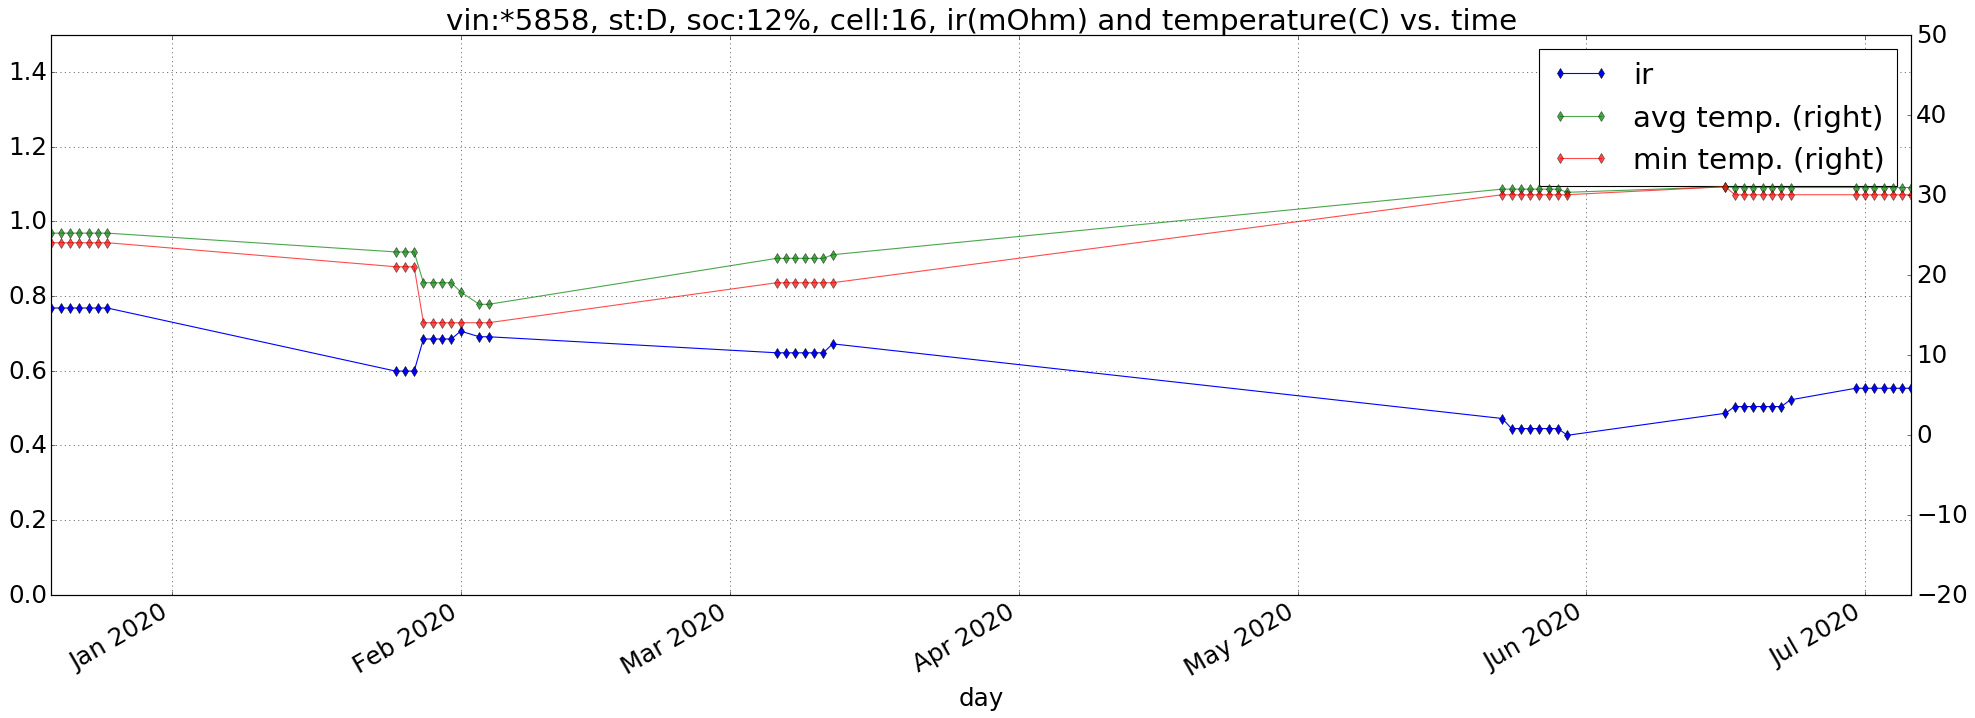

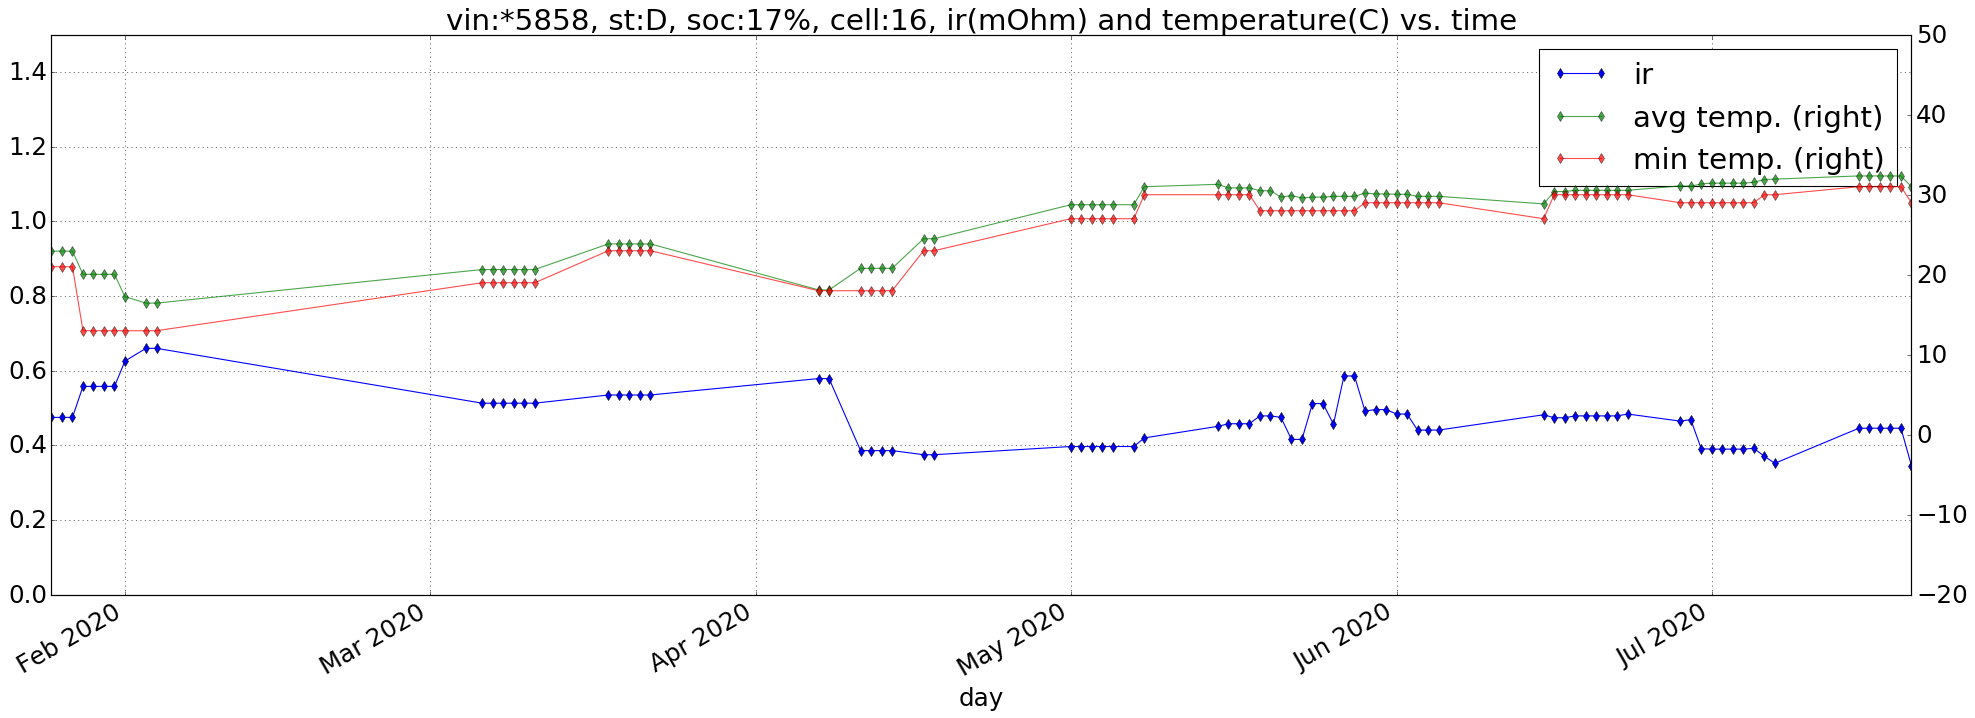

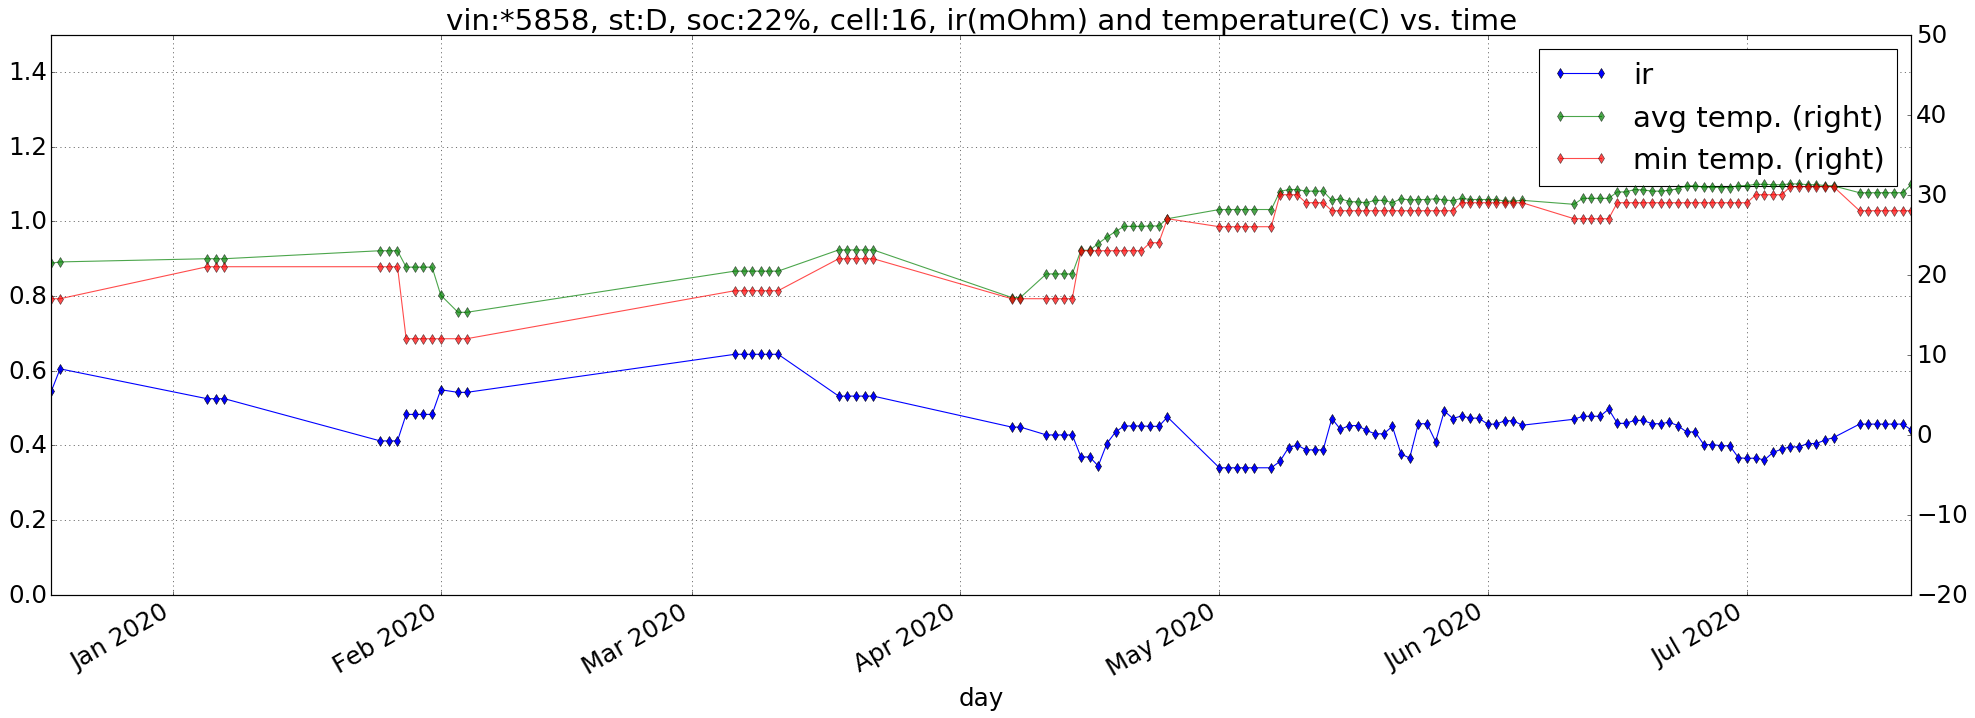

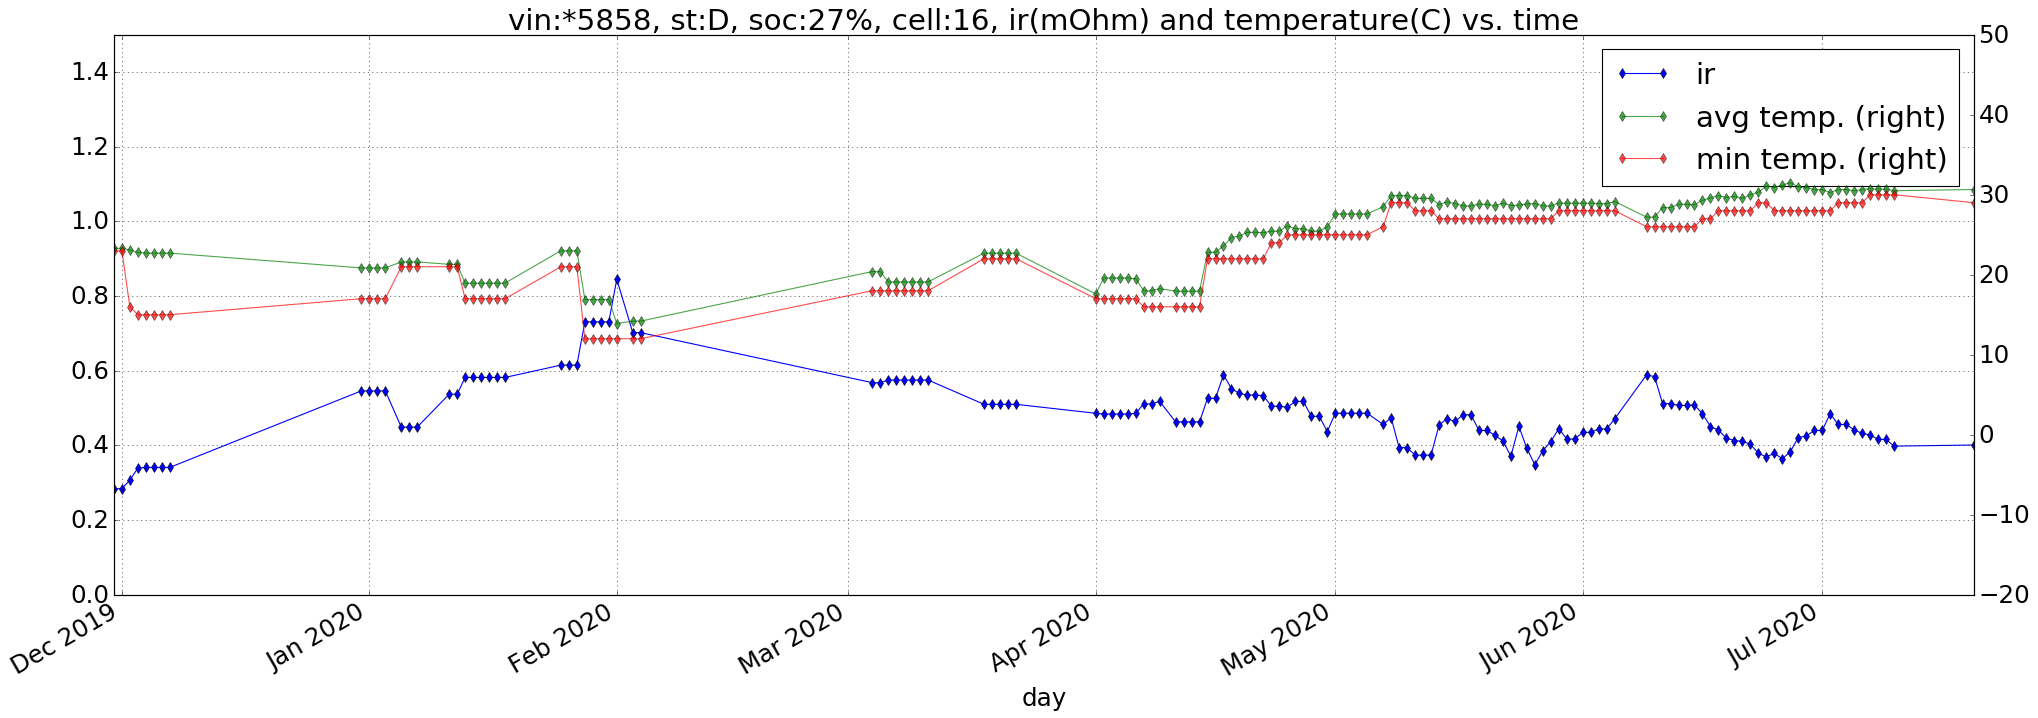

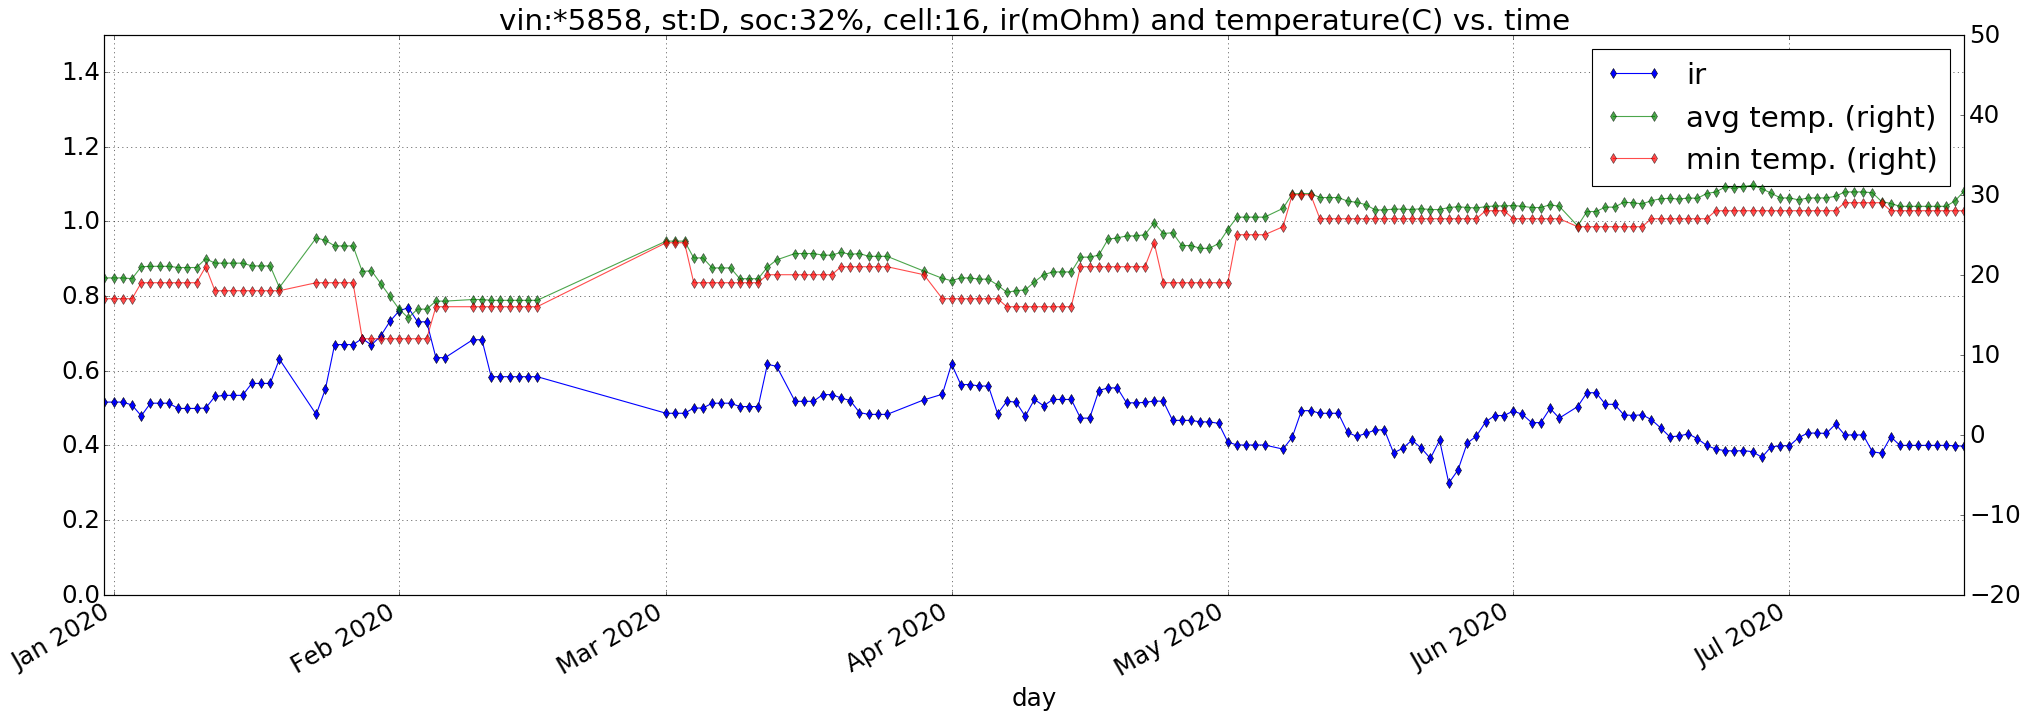

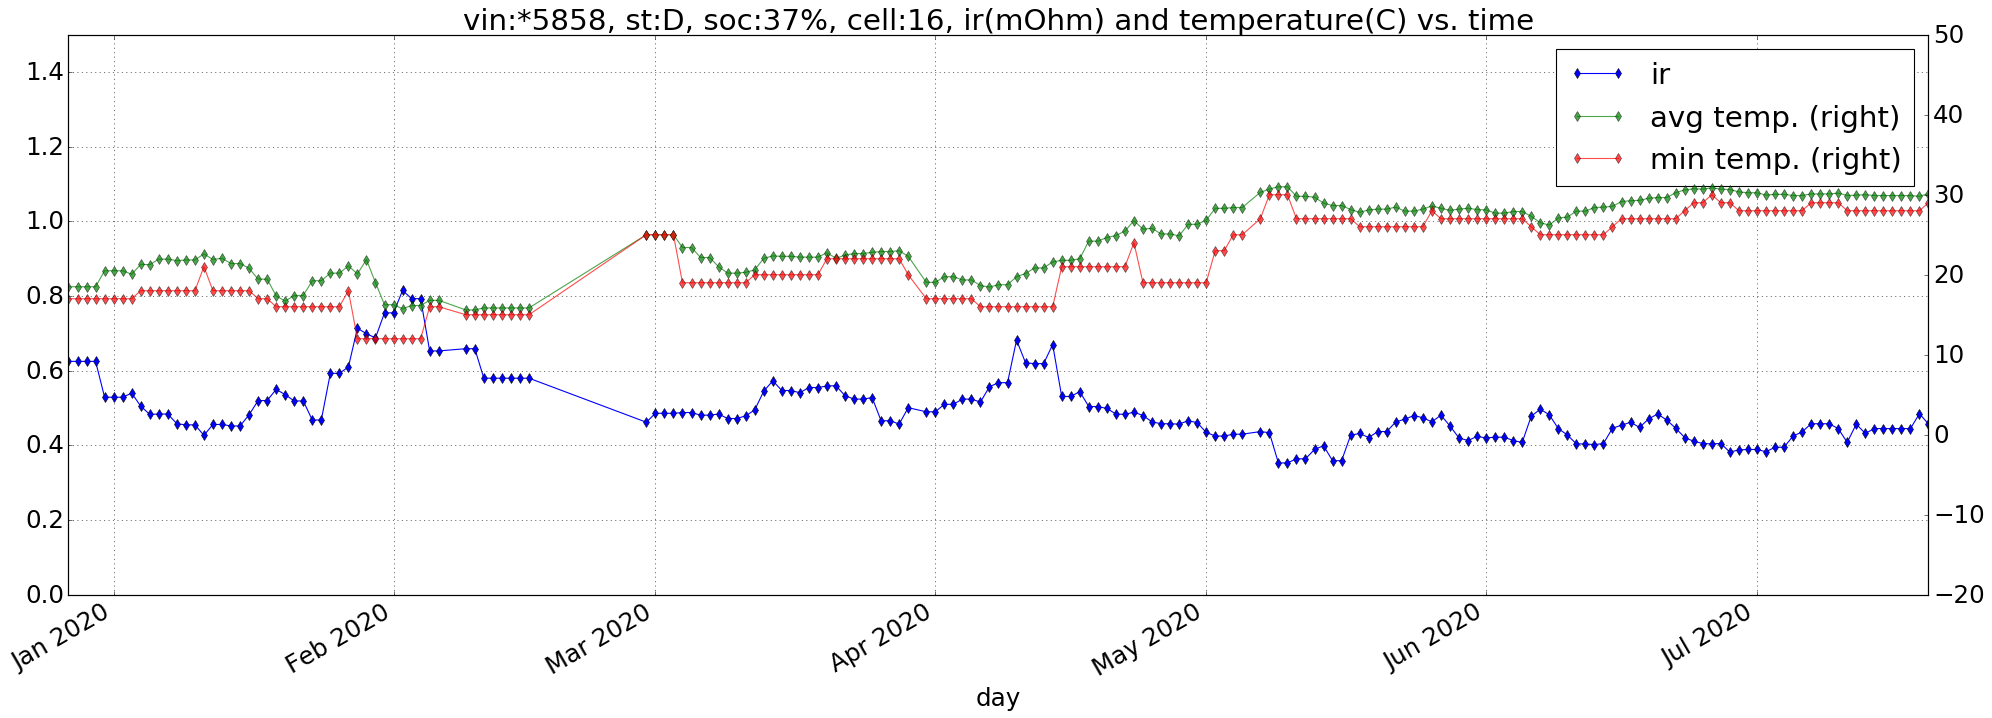

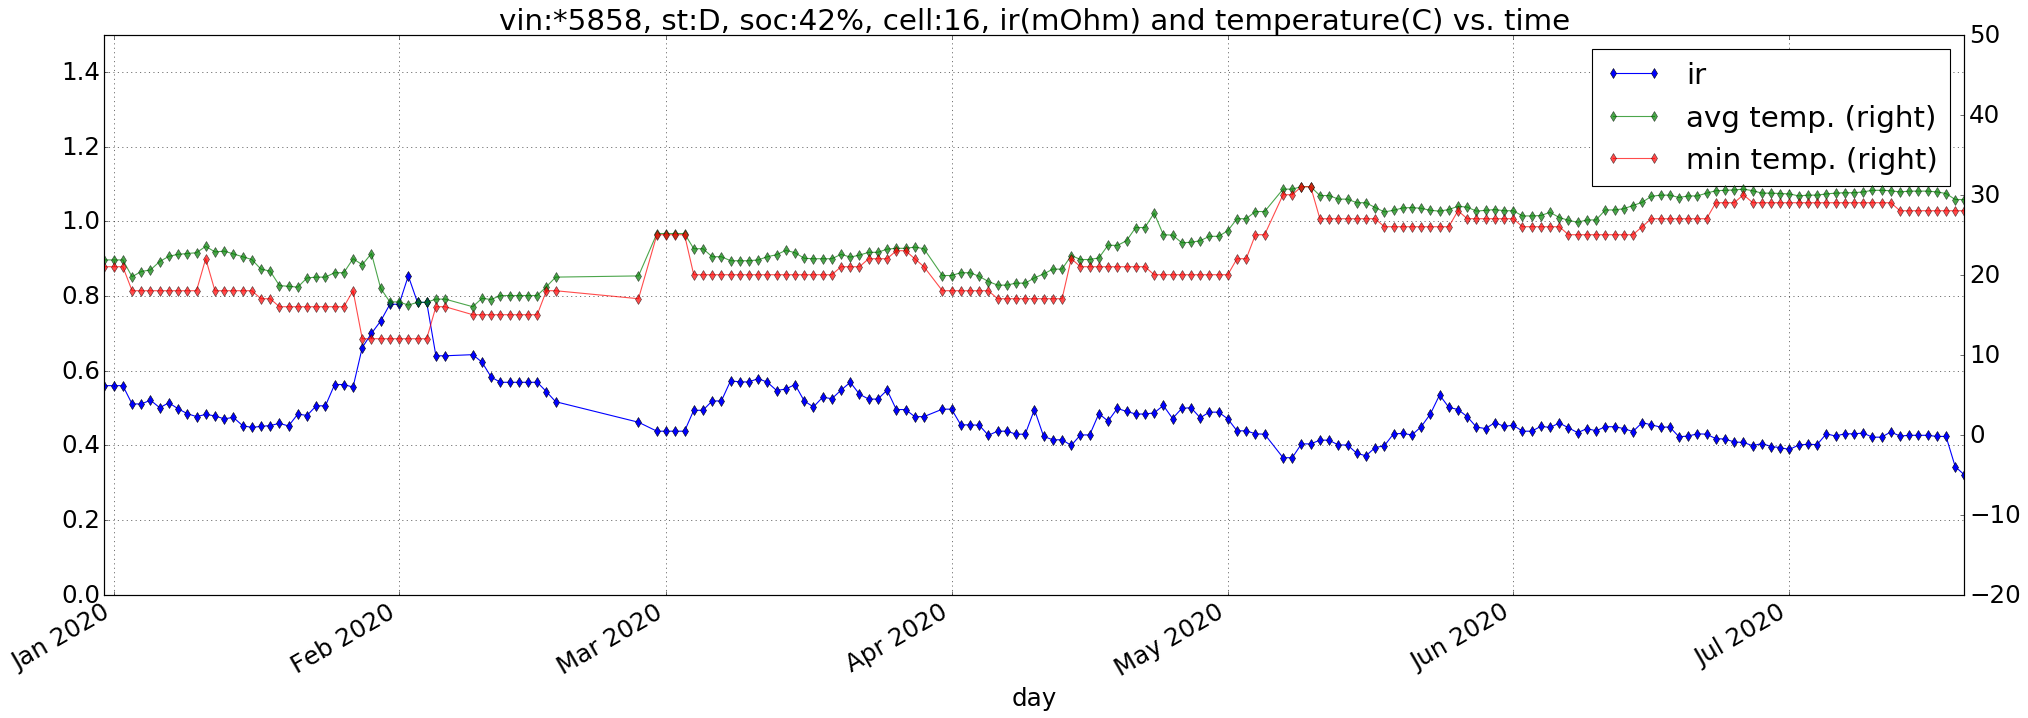

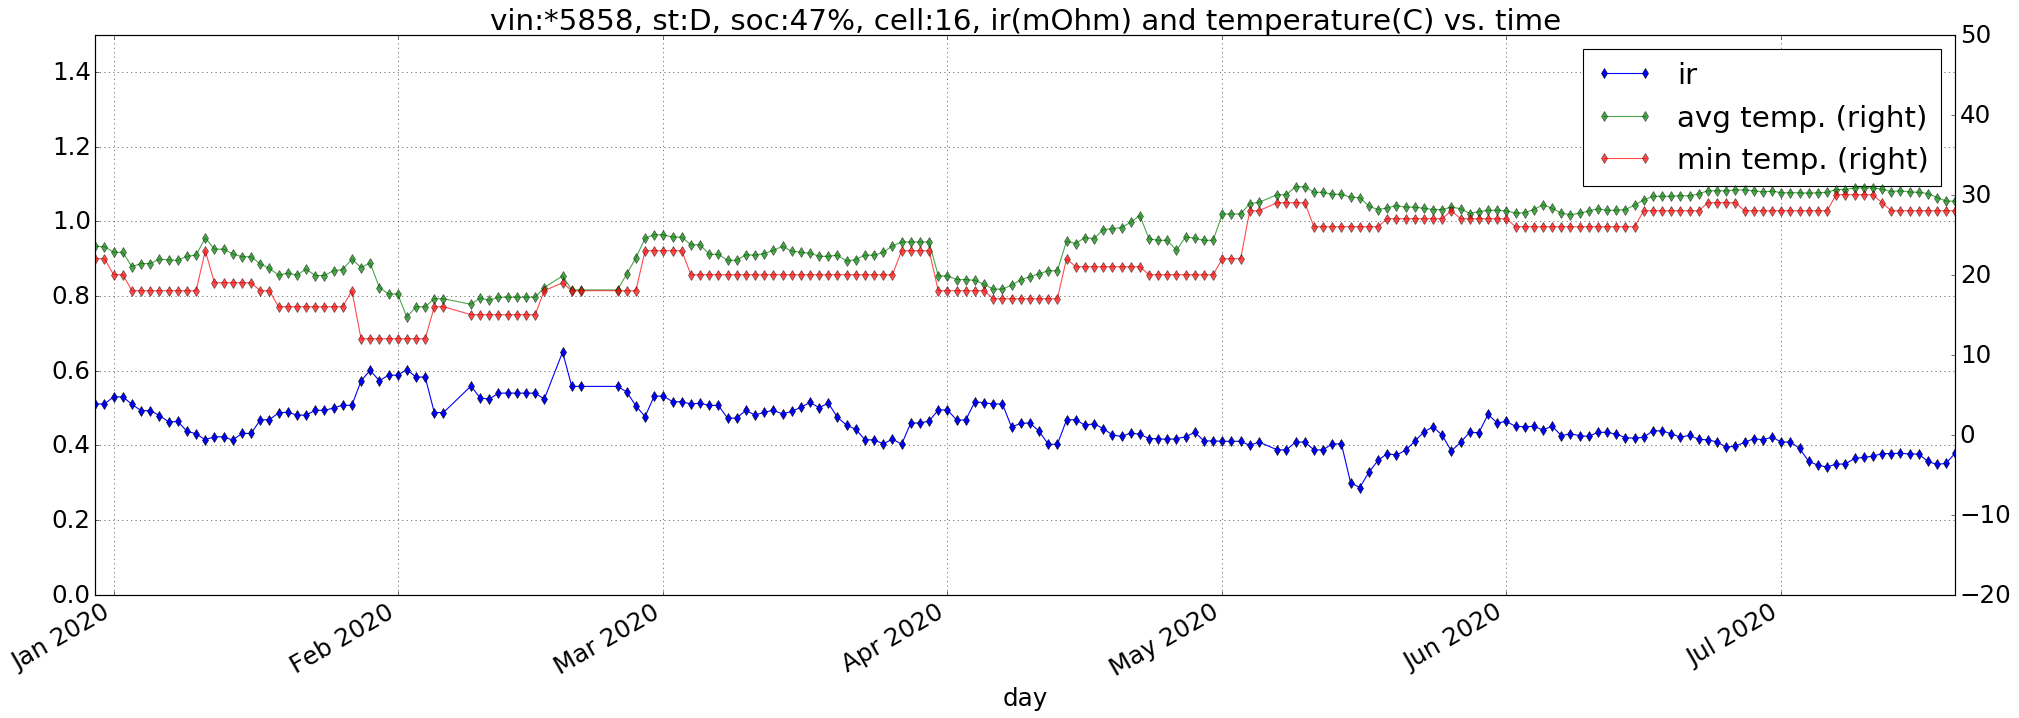

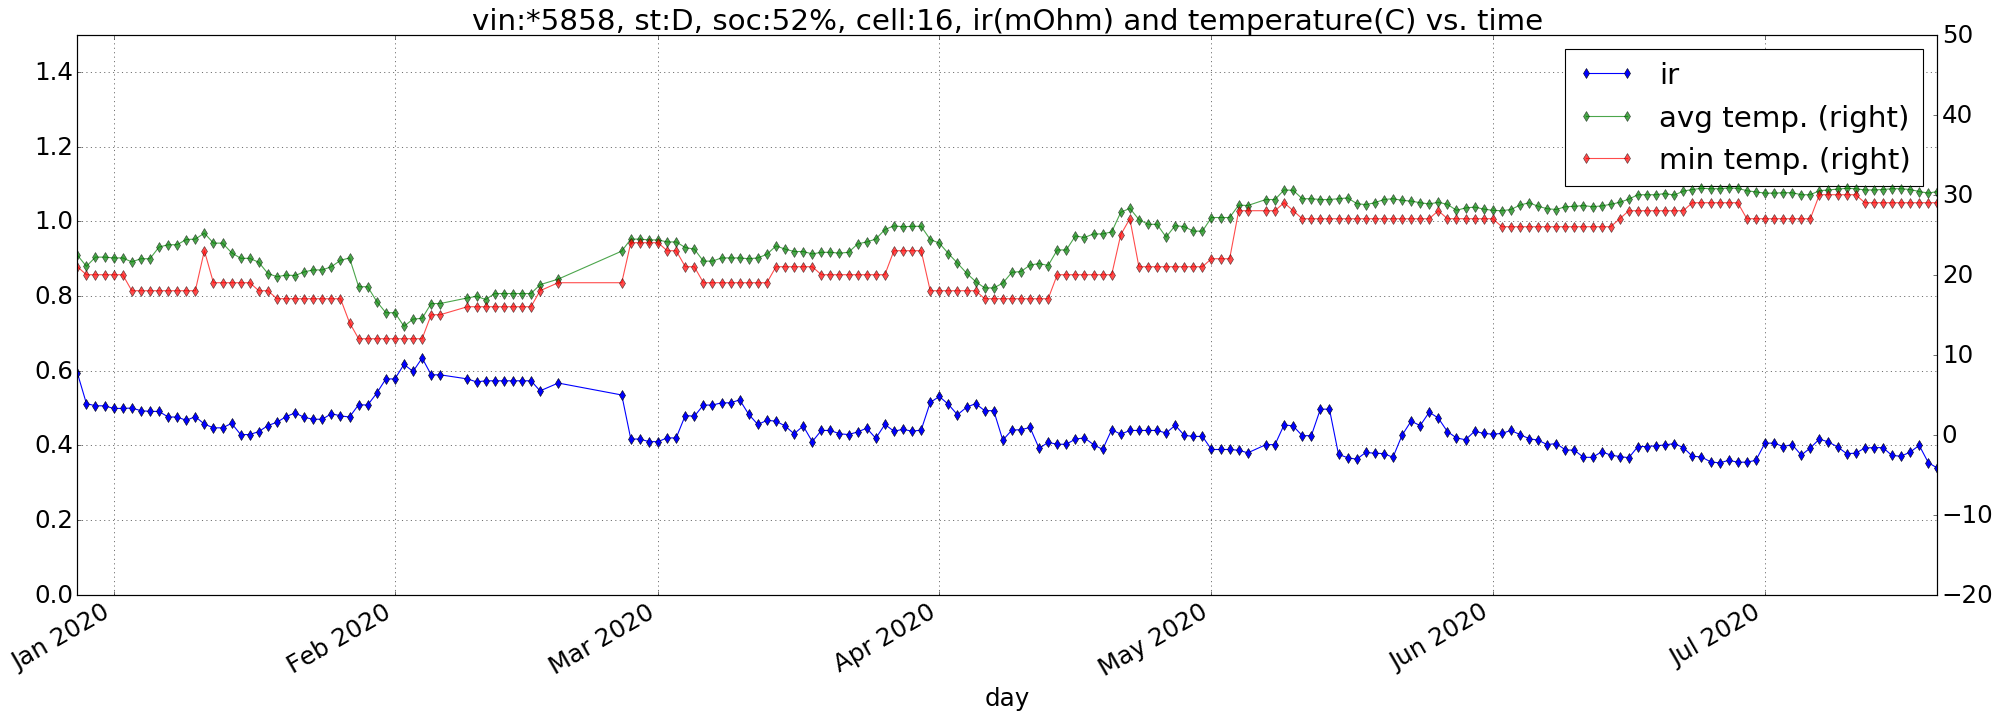

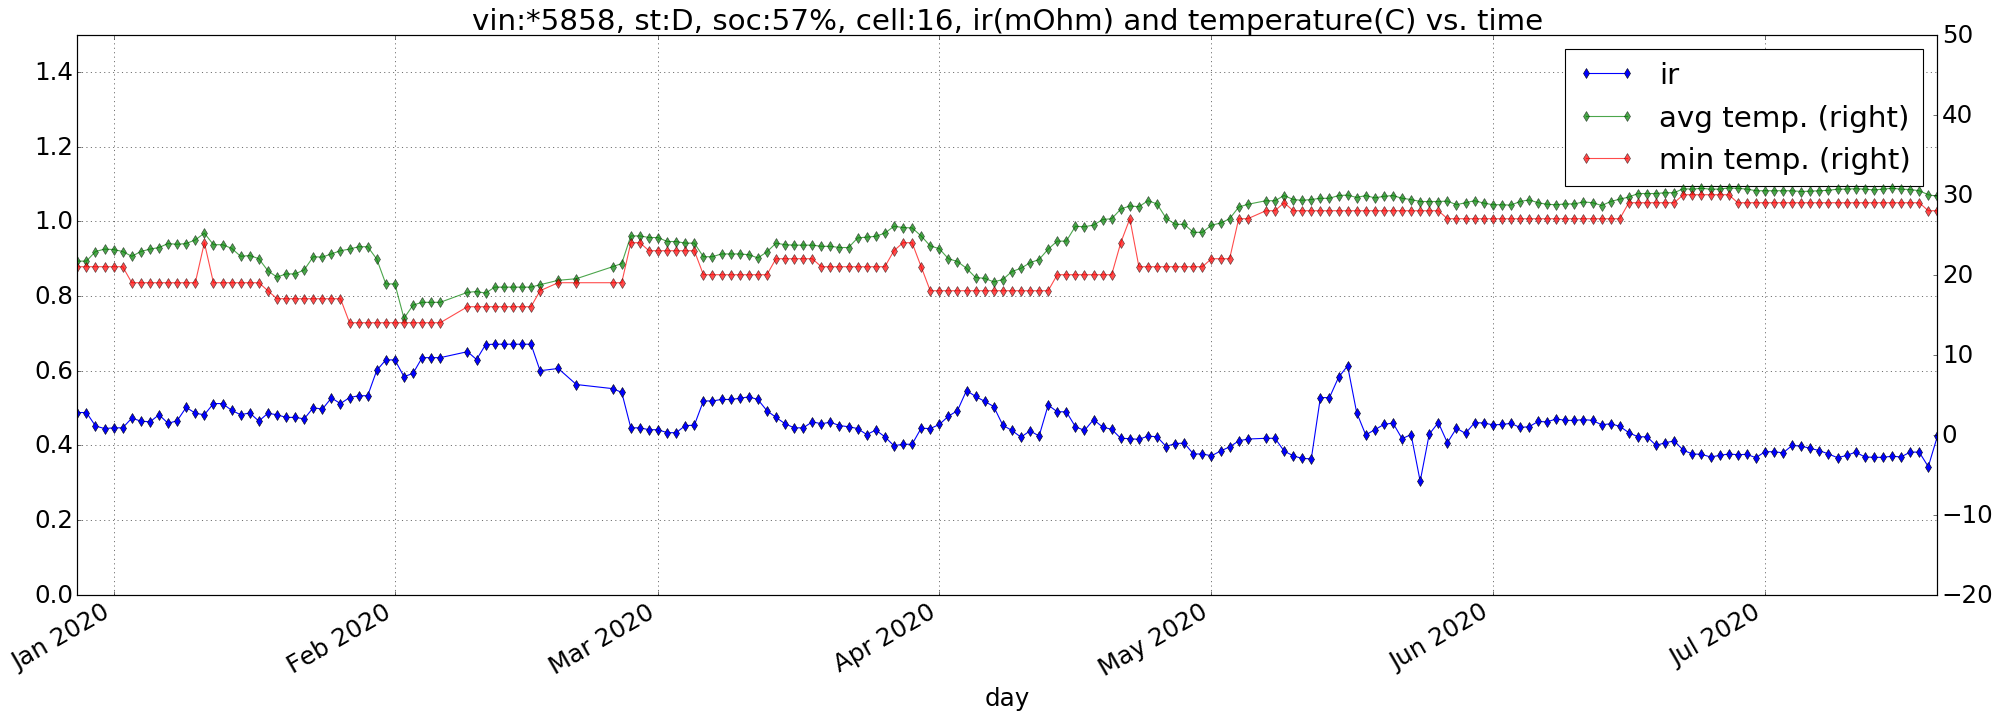

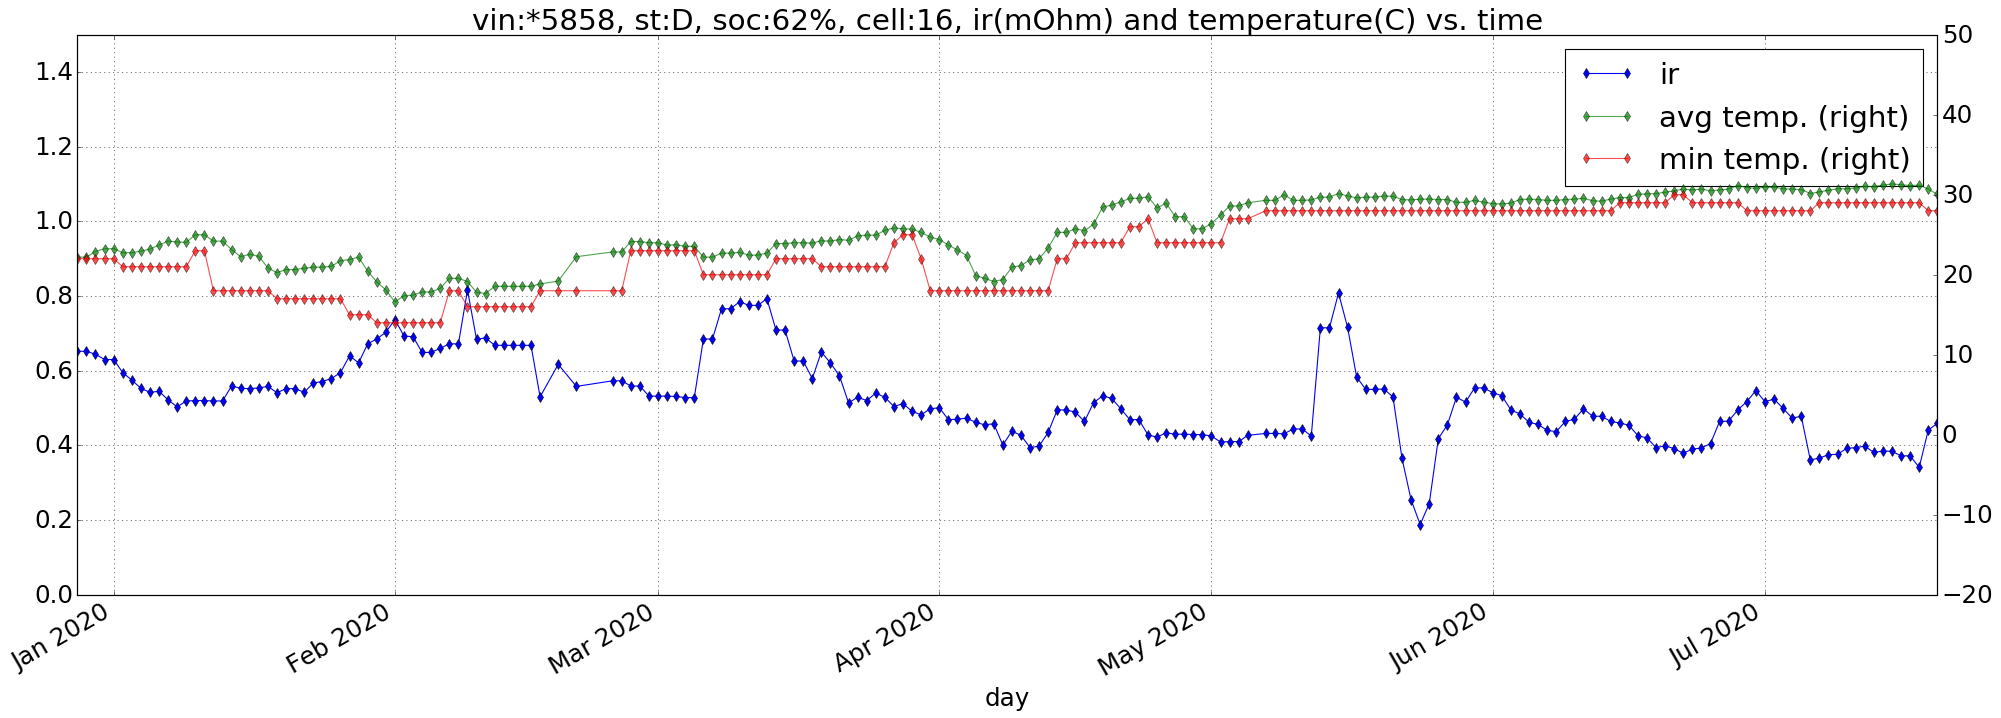

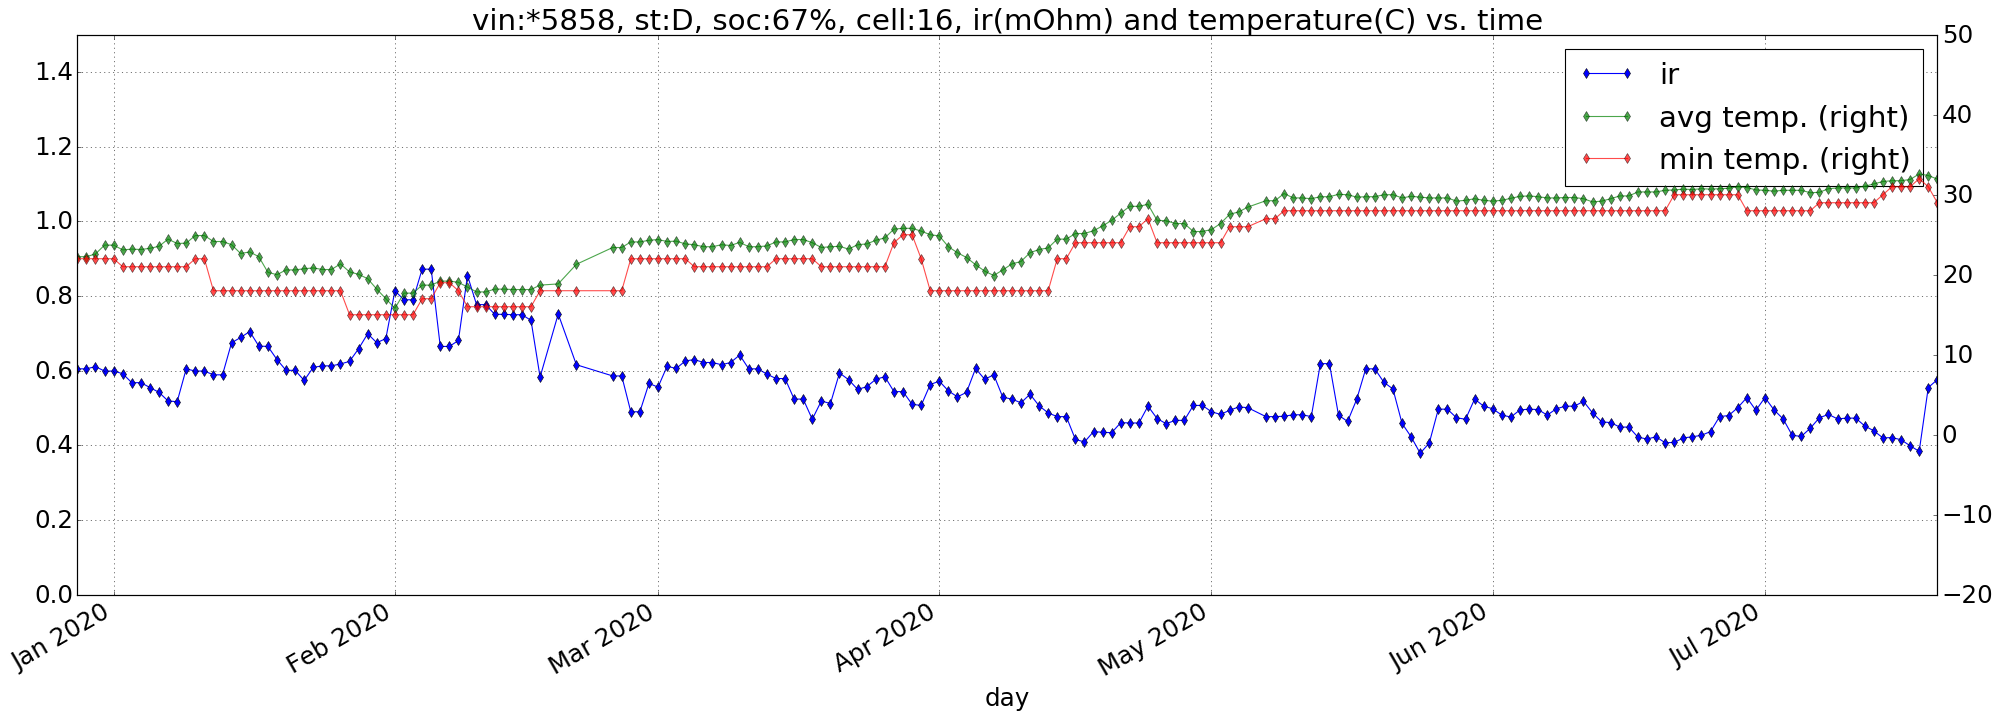

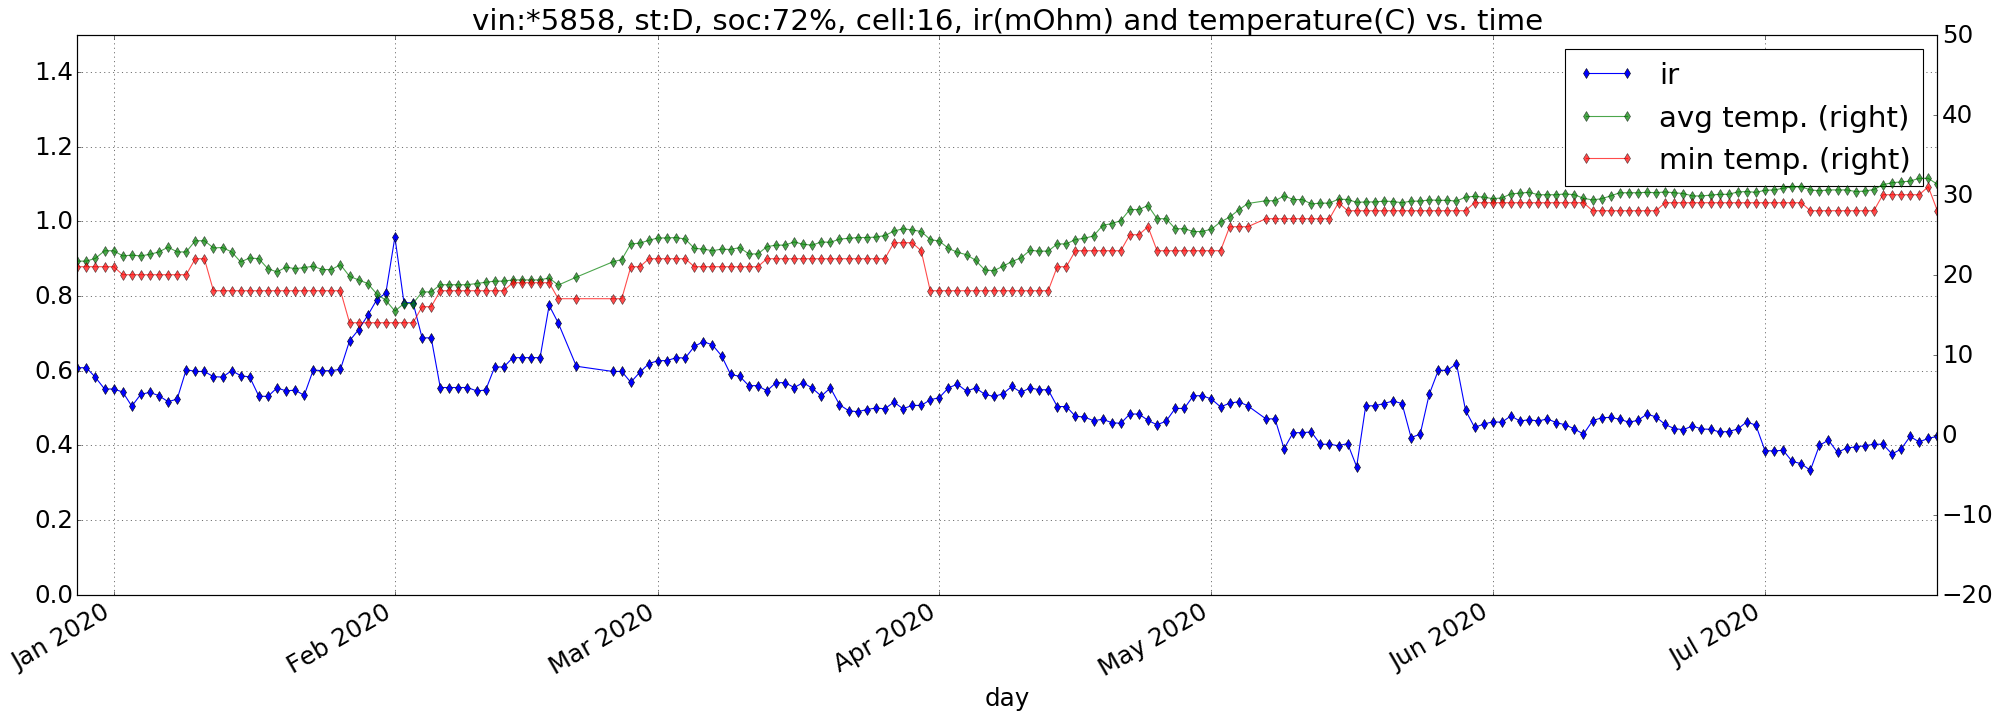

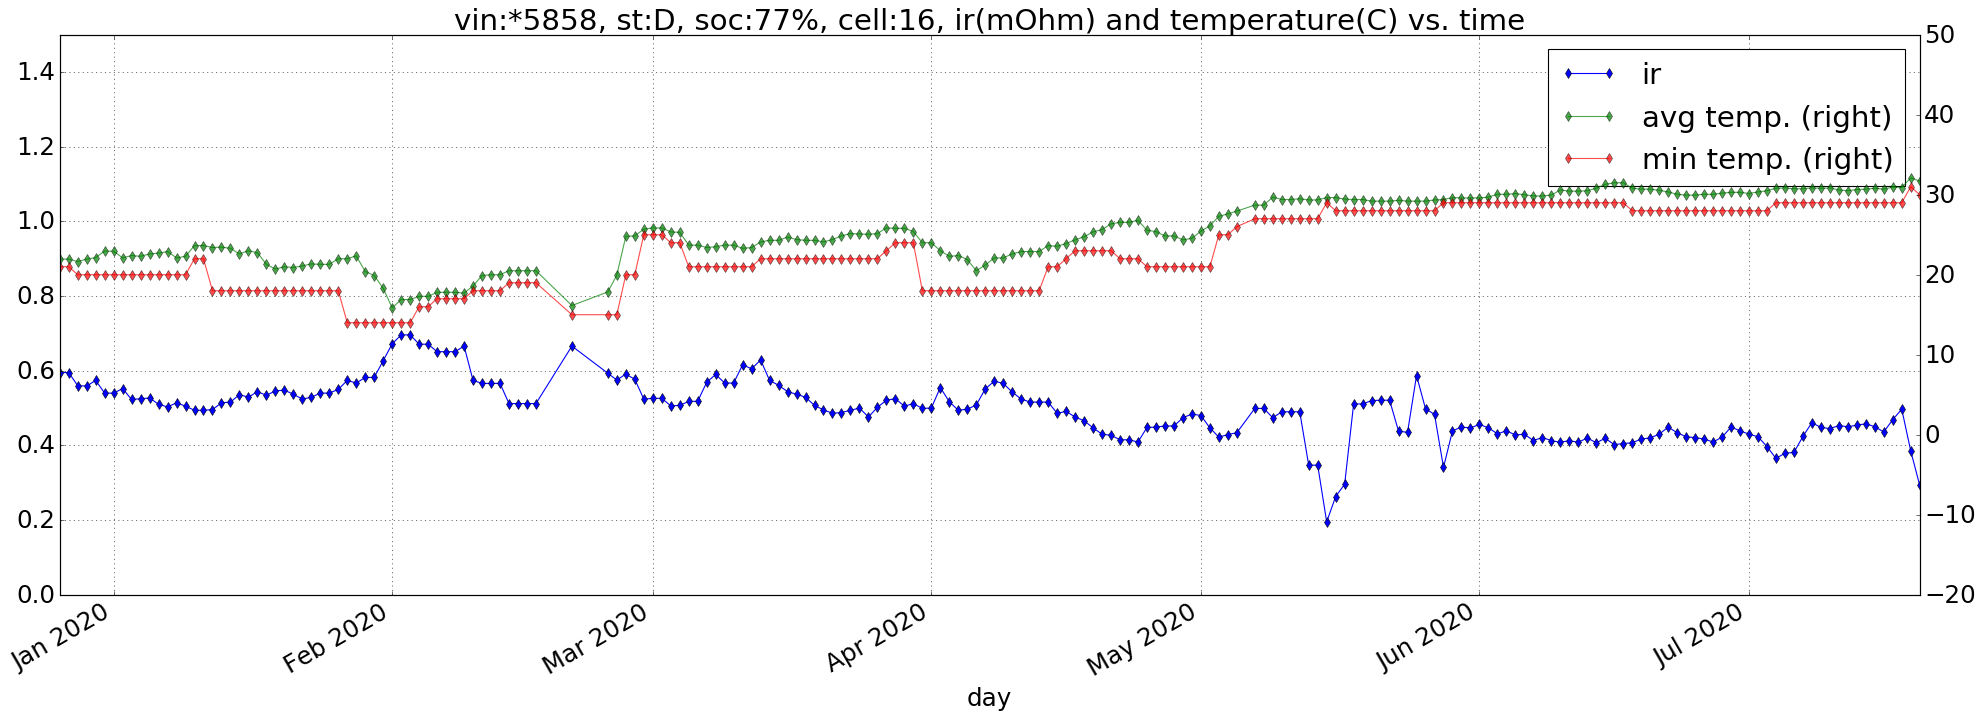

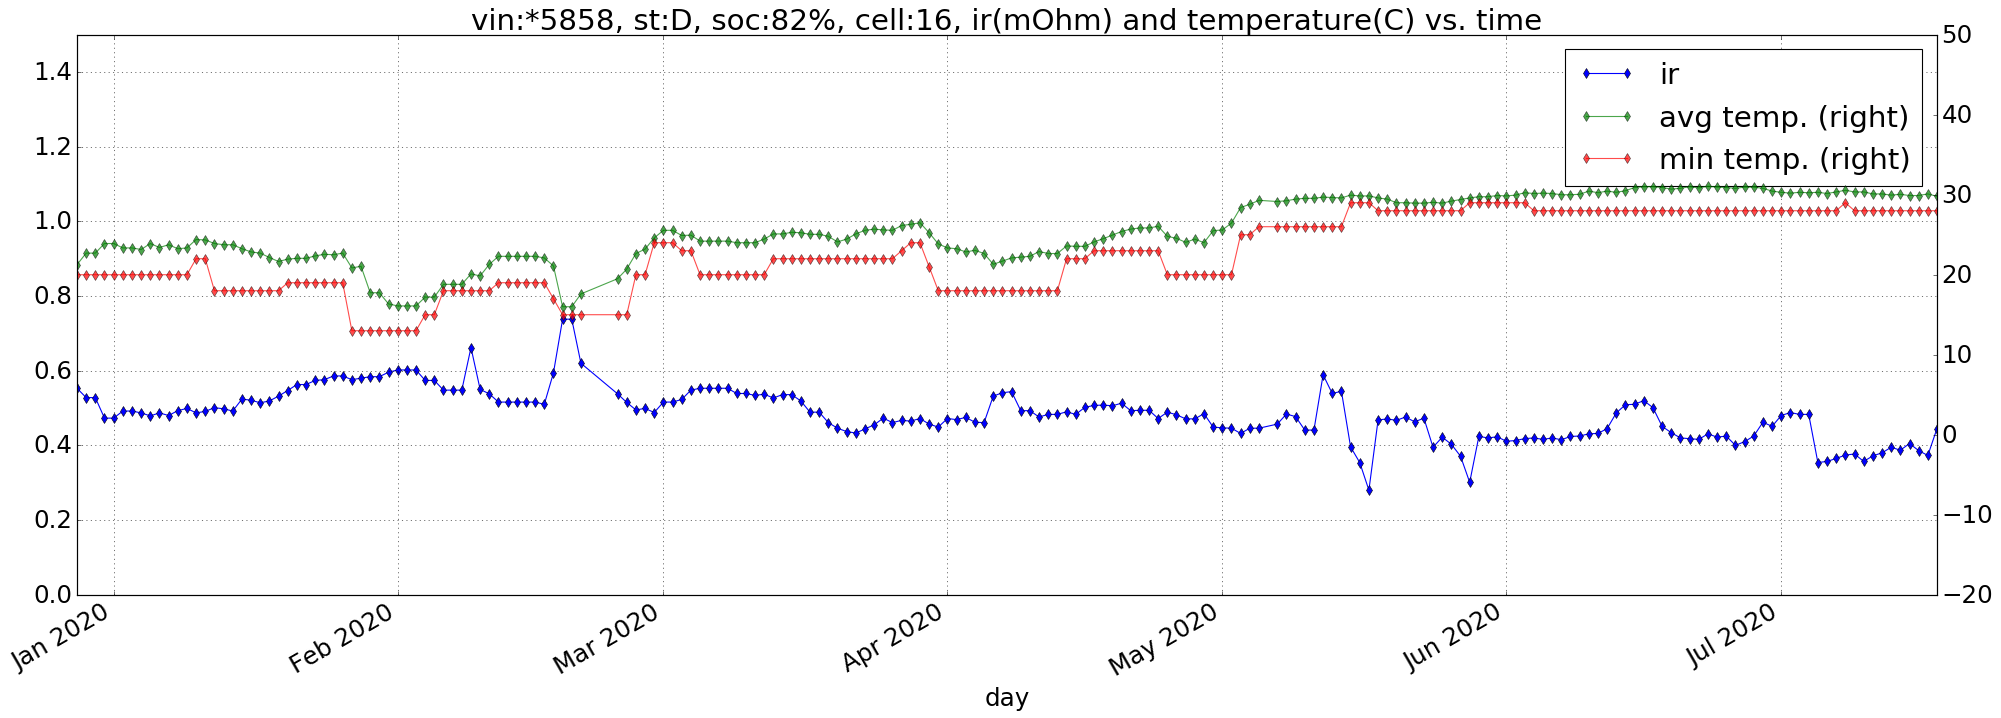

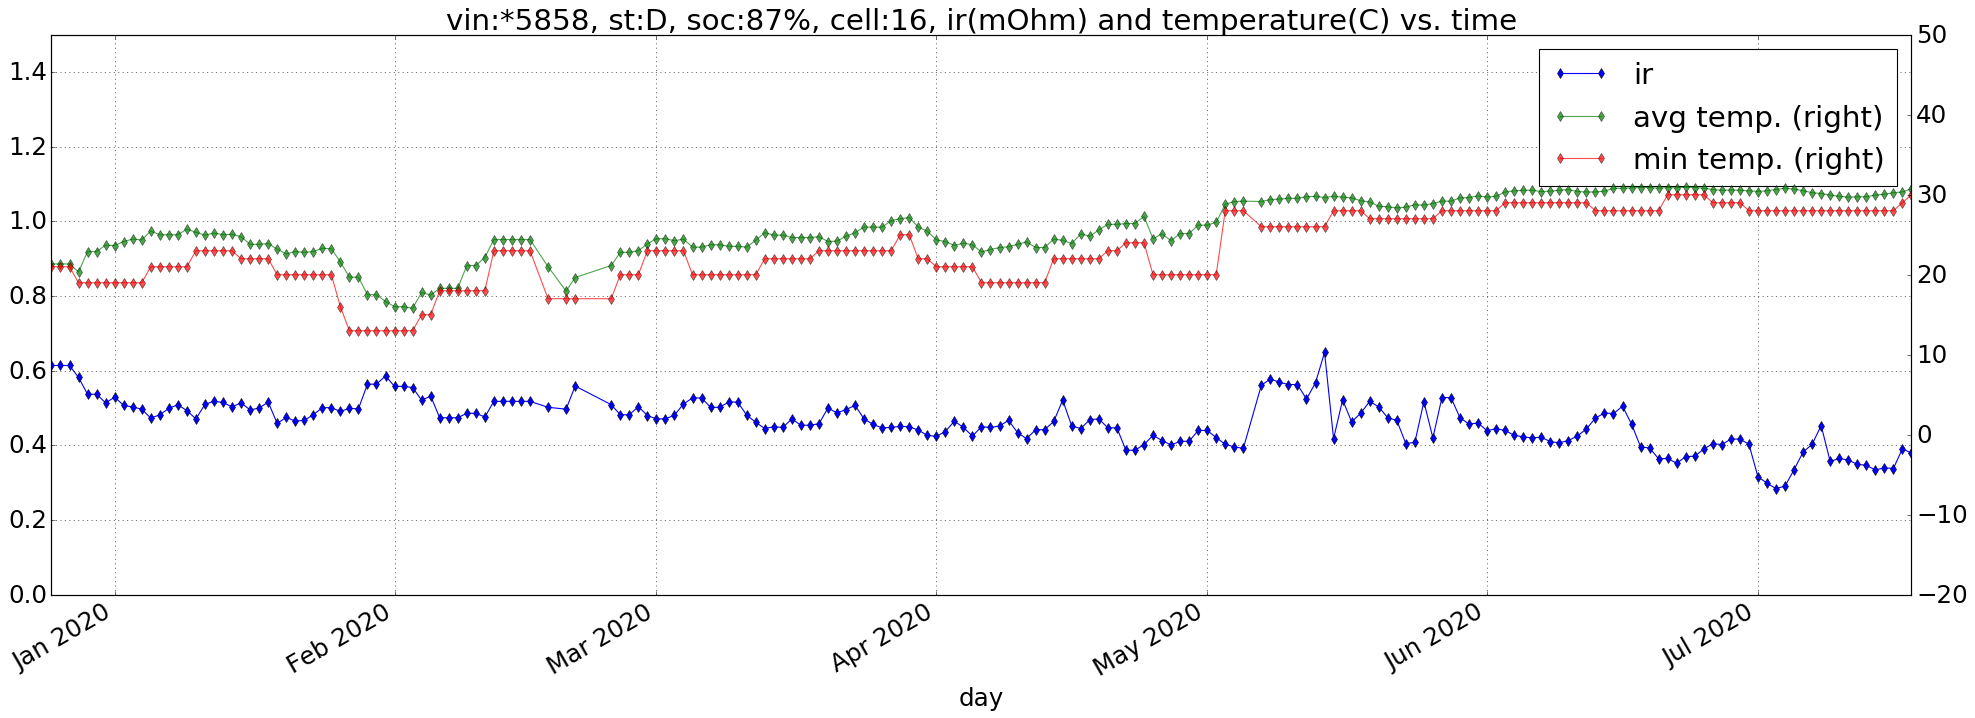

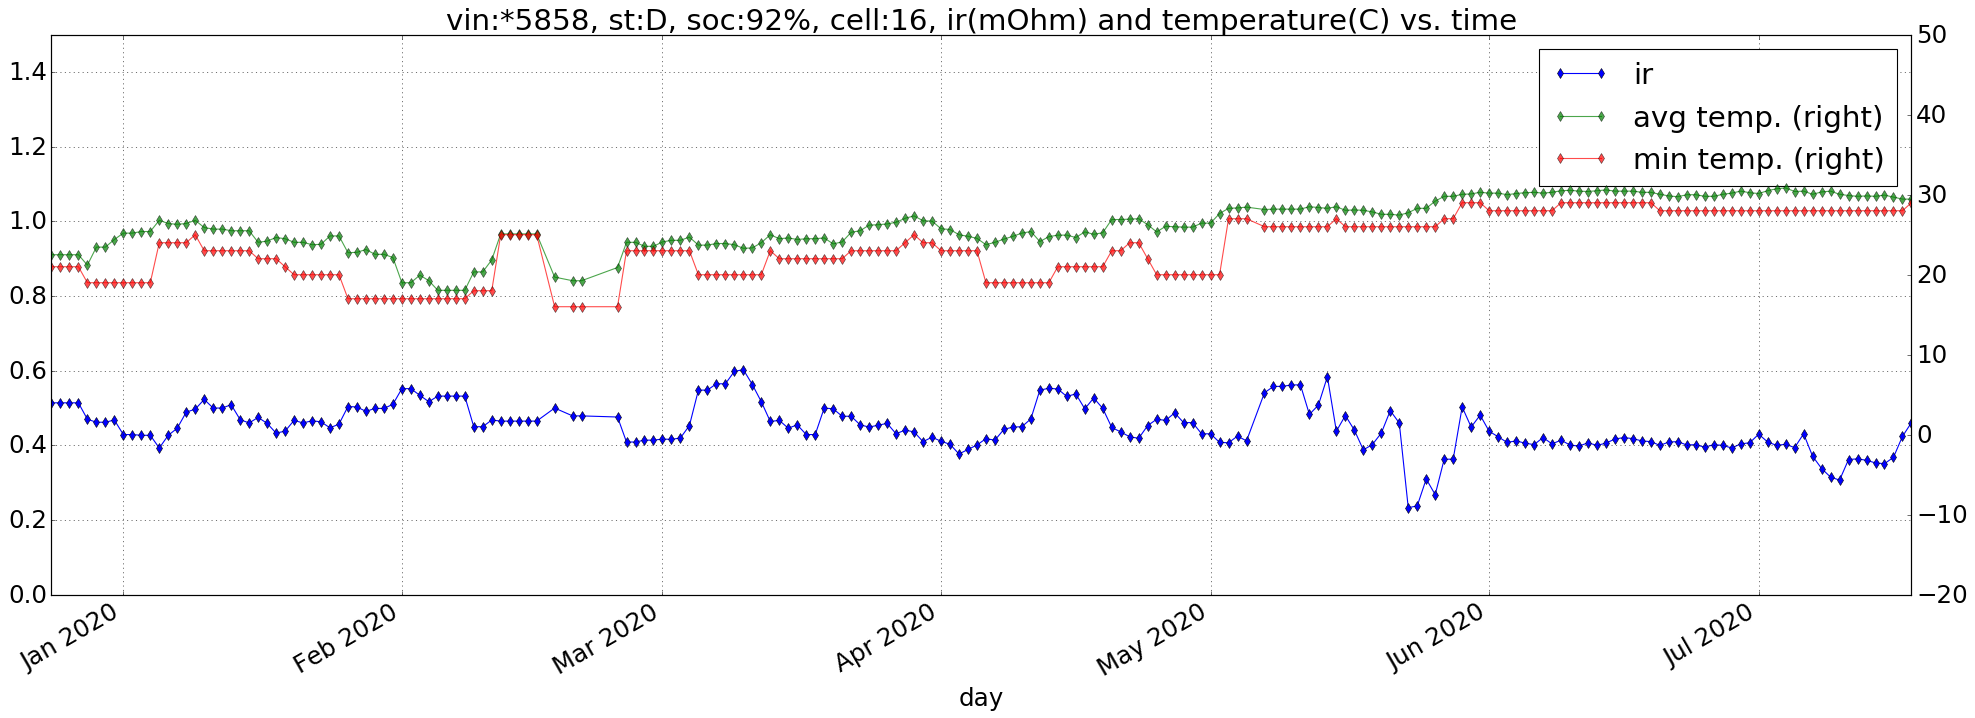

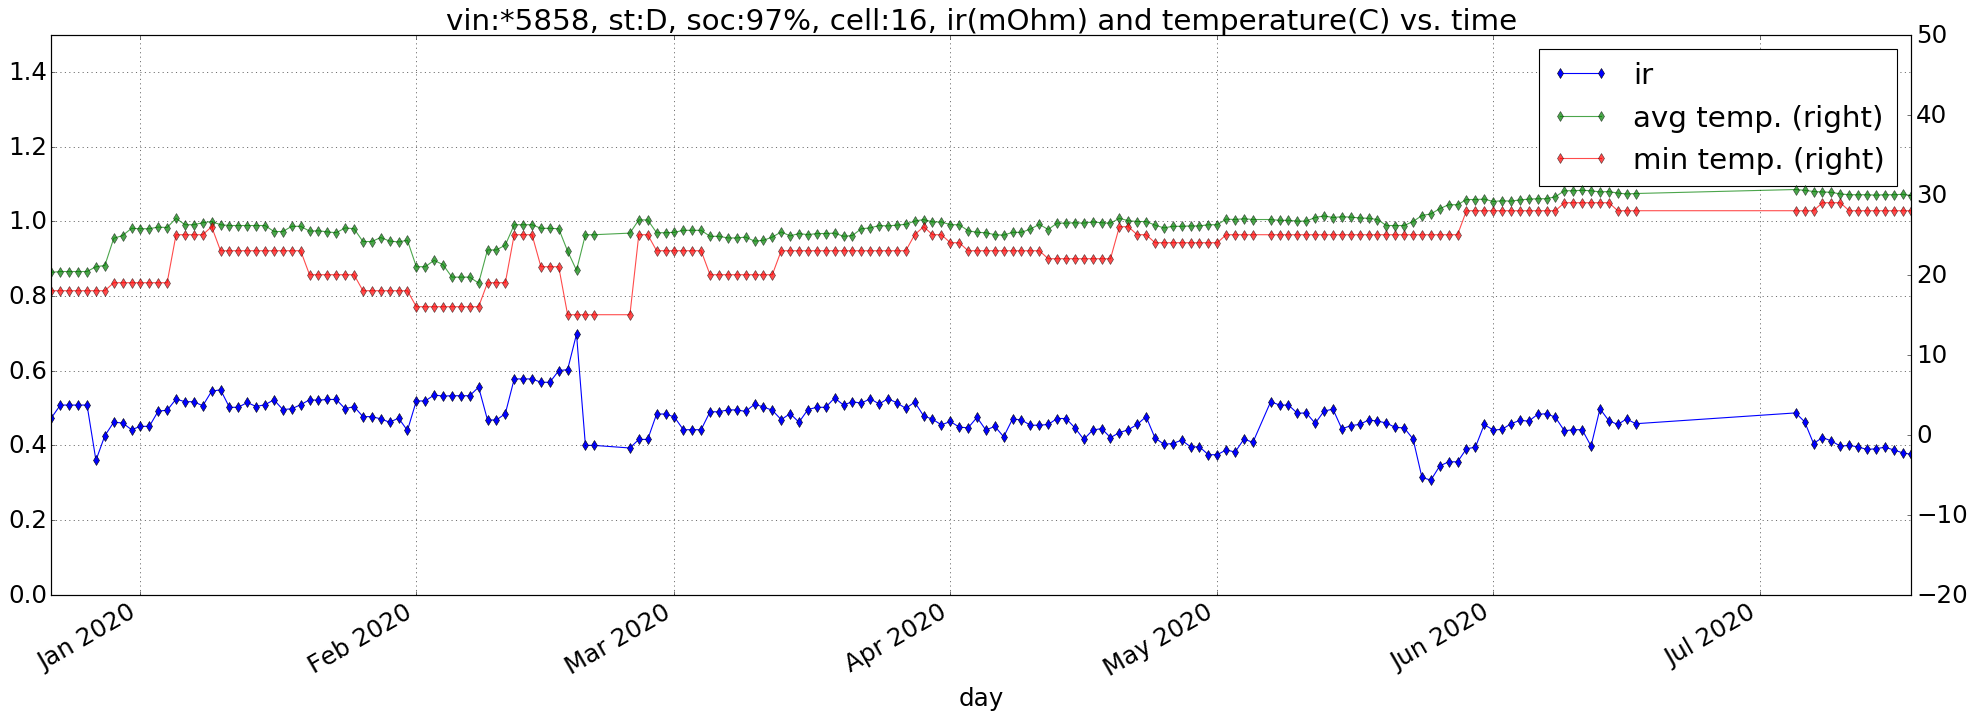

In [7]:
# veh_states can be either ['D'], ['C'], 'D', 'C' or None (== ['D', 'C'])
# socs can be either [7], 7, or None (== all available soc windows); soc values should be 5*x + 2 or 10*x +2 (e.g., 12, 17)
# cell_ids can be either [1, 9, 10] or 1, or None(== all 92 cells)
# ir_ylim is the vertical plot limit for ir, defaut is (0.0, 1.5)
# temp_ylim is the vertial plot limit for temperature, default is (-20, 40)

# please remember to run the second cell twice, the second time is after generating first plot,
# then all the later plots will have larger font size

generate_plot('LNAA2AA19K5025858', veh_states=['D'], socs=None, cell_ids=16, ir_ylim=(0., 1.5), temp_ylim=(-20, 50))

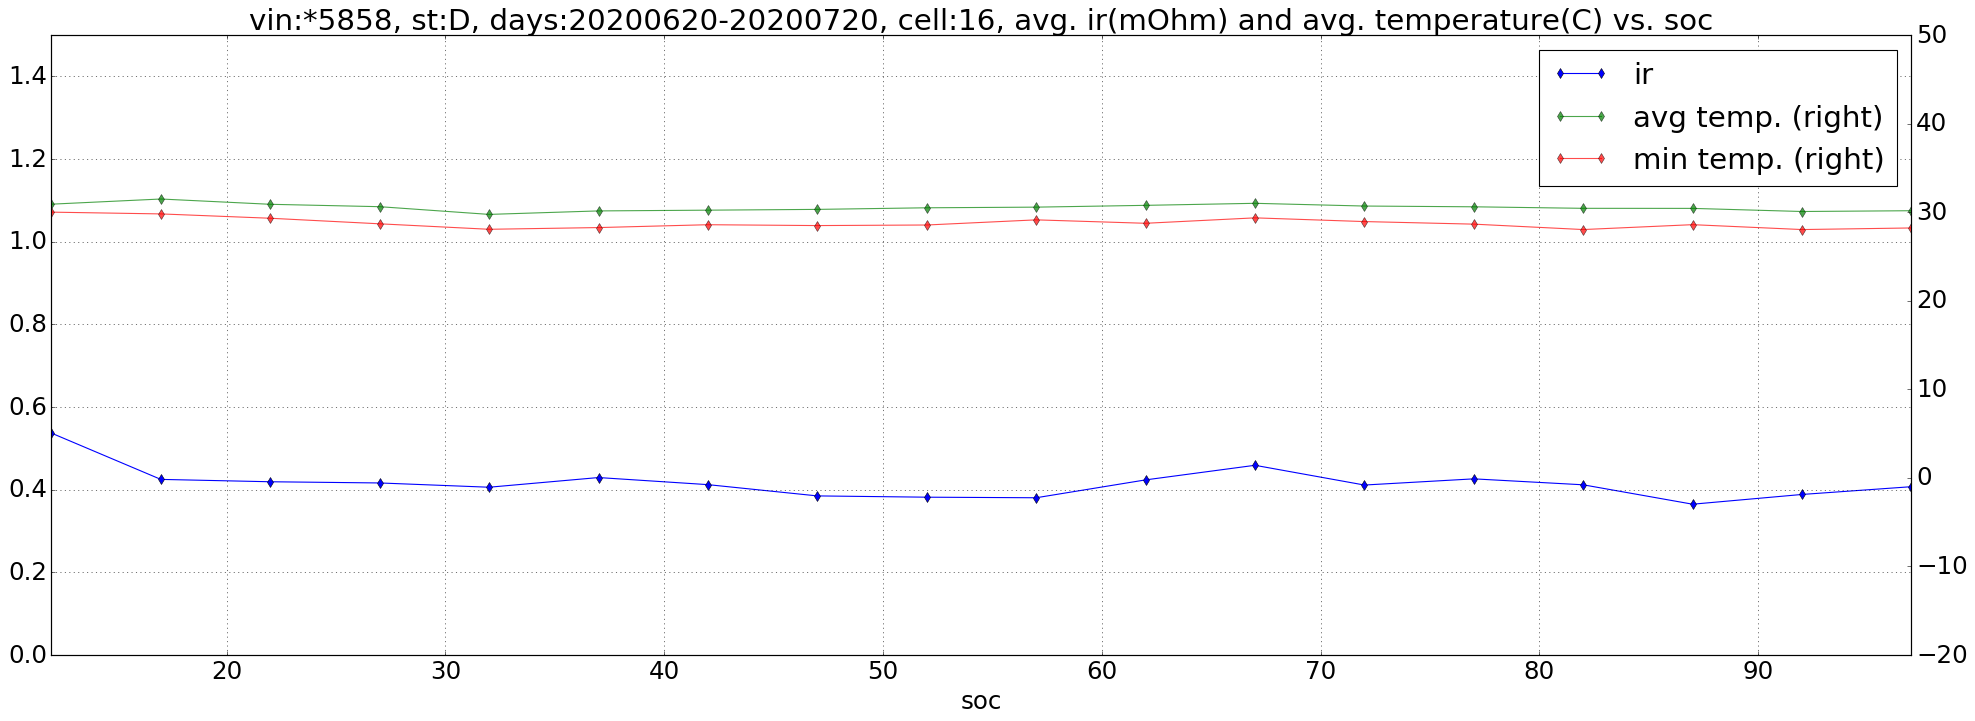

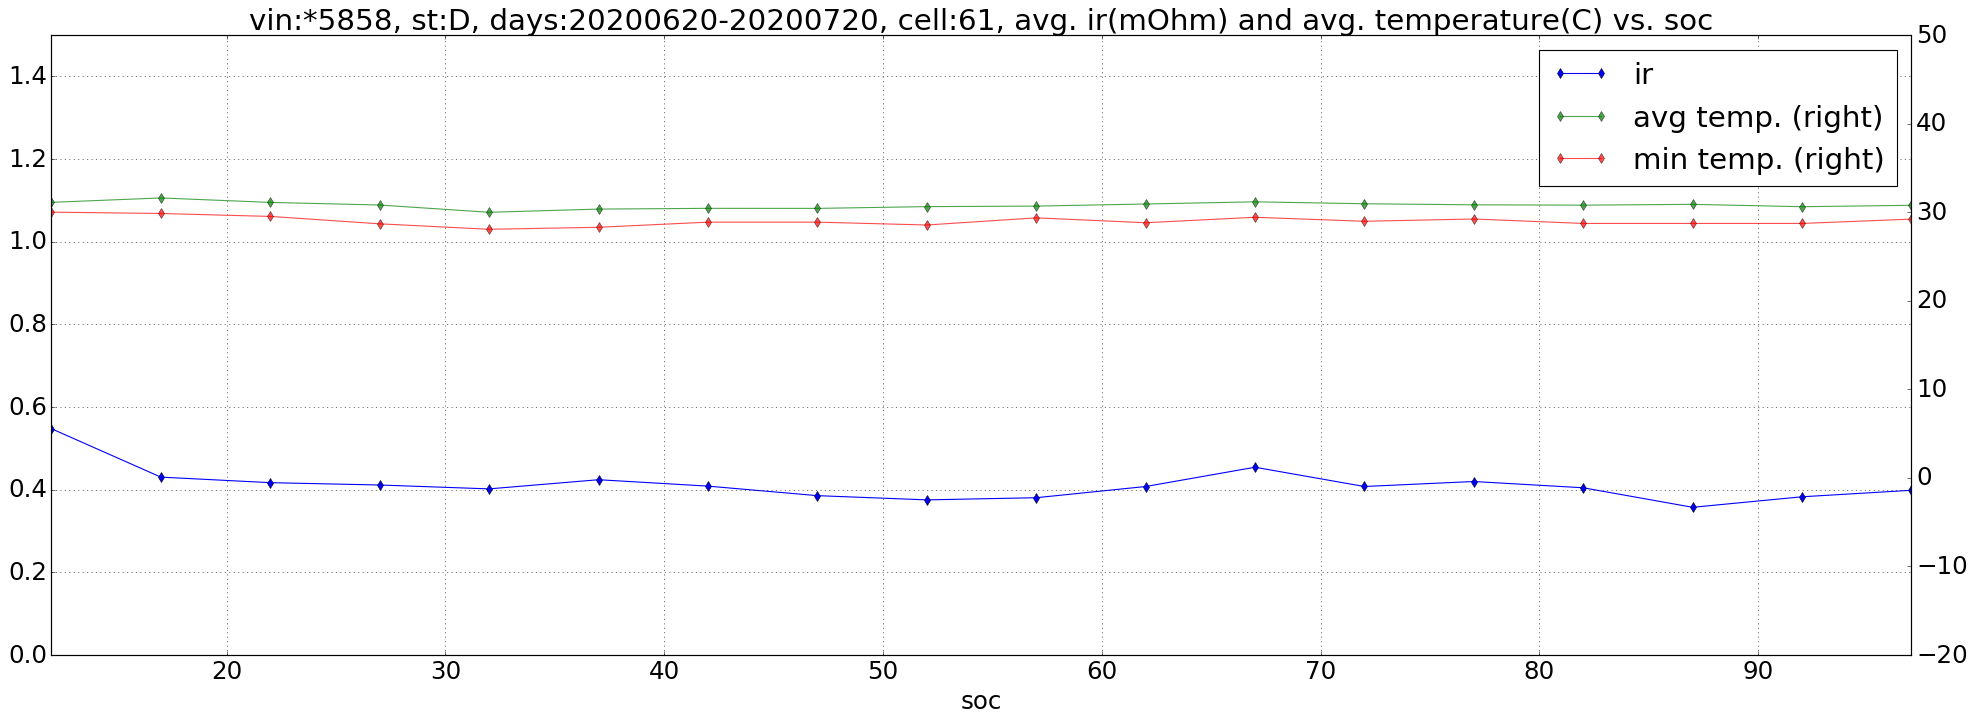

In [8]:
# veh_states can be either ['D'], ['C'], 'D', 'C' or None (== ['D', 'C'])
# sdate can be 'YYYYMMDD' or None (== earliest available day)
# edate can be 'YYYYMMDD' or None (== latest available day)
# cell_ids can be either [1, 9, 10] or 1, or None(== all 92 cells)
# ir_ylim is the vertical plot limit for ir, defaut is (0.0, 1.5)
# temp_ylim is the vertial plot limit for temperature, default is (-20, 40)

# please remember to run the second cell twice, the second time is after generating first plot,
# then all the later plots will have larger font size

generate_plot2('LNAA2AA19K5025858', veh_states=['D'], sdate='20200620', edate=None, cell_ids=[16, 61], ir_ylim=(0., 1.5), temp_ylim=(-20, 50))